In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Loading data to pandas dataframe:

In [91]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.columns.values)
train_df.head()

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Check if there are missing values in training data:

In [3]:
print(train_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [4]:
columns = train_df.columns.values
index, = np.where(columns == 'Survived')
features = np.delete(columns, index)
data = pd.DataFrame(train_df, columns = features)
data.shape

(891, 11)

Age, Cabin and Embarked columns contain missing values in training data.

To use Gaussian Naive Bayes features should have continuous values.
Ideally, if they are sampled from normal distribution.
Let's look which types of features there are in our data.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 59.2+ KB


Only Age and Fare are continuous. Further we should check if they have normal distribution.
PassengerId doesn't contain any useful information, so we won't use it for training. 
Cabin has a lot of missing values, so we won't use it. 

Name, ticket and Cabin are text features not correlated with target Survived column.

Let's see how Age feature is distributed. 

c:\users\nadine\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\nadine\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


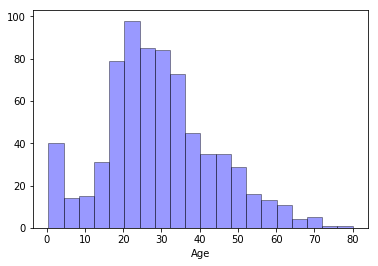

In [6]:
sns.distplot(data['Age'], hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})

Missing values in Age column are indicated as NaN. We may use scikit-learn SimpleImputer to impute NaNs with median values. 

In [7]:
train_df[train_df['Age'].isnull() == True].Age.head()

5    NaN
17   NaN
19   NaN
26   NaN
28   NaN
Name: Age, dtype: float64

In [8]:
from sklearn.impute import SimpleImputer
imp_age_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_age_median.fit(np.asmatrix(data['Age']).T)
imputed_age = imp_age_median.transform(np.asmatrix(data['Age']).T)
data['Age'] = imputed_age

Are there any missing Age values after imputing?

In [9]:
data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Let's use PowerTransformer to make Age distribution more Gaussian. 

In [10]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
pt.fit(np.asmatrix(data['Age']).T)

PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

In [11]:
transformed_age = pt.transform(np.asmatrix(data['Age']).T)
data['Age'] = transformed_age

We will convert Sex feature with values male and female to numerical values with scikit-learn Label Encoder.


In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data['Sex'].unique())

LabelEncoder()

In [13]:
list(le.classes_)

['female', 'male']

In [14]:
encoded_sex = le.transform(data['Sex'])
data['Sex'] = encoded_sex

Embarked feature has 3 categorical values. 

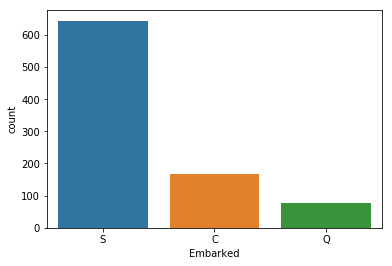

In [15]:
sns.countplot(data['Embarked'])

Train data contains 2 missing values in Embarked column. We will impute them with SimpleImputer for categorical data.

In [16]:
data['Embarked'].isnull().sum()

2

In [17]:
cat_imp = SimpleImputer(strategy="most_frequent")
cat_imp.fit(np.asmatrix(data['Embarked']).T)     

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)

In [18]:
imputed_emb = cat_imp.transform(np.asmatrix(data['Embarked']).T)
data['Embarked'] = imputed_emb

In [19]:
data['Embarked'].isnull().sum()

0

Now convert Embarked to numerical values.

In [20]:
ports = data['Embarked'].unique()

In [21]:
le_port = preprocessing.LabelEncoder()
le_port.fit(ports)
list(le_port.classes_)
encoded_port = le_port.transform(data['Embarked'])
data['Embarked'] = encoded_port

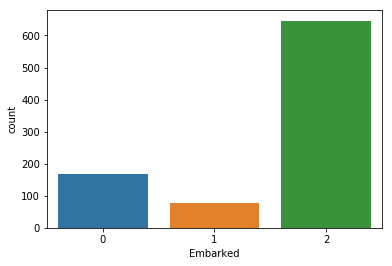

In [22]:
sns.countplot(data['Embarked'])

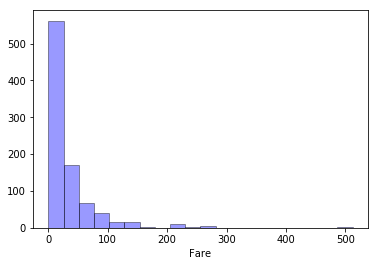

In [23]:
#plot Fare distribution with seaborn
sns.distplot(data['Fare'], hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})

In [24]:
data['Fare'].isnull().sum()

0

In [25]:
data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [26]:
fare_pt = PowerTransformer()
fare_pt.fit(np.asmatrix(data['Fare']).T)

PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

In [27]:
transformed_fare = fare_pt.transform(np.asmatrix(data['Fare']).T)
data['Fare'] = transformed_fare

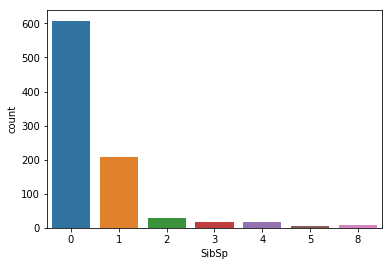

In [28]:
sns.countplot(data['SibSp'])

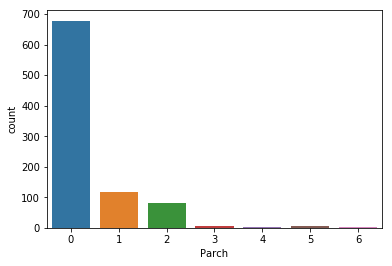

In [29]:
sns.countplot(data['Parch'])

From two features lets create another feature - family size. Then remove those two features and unuseful text features

In [30]:
data['FamilySize'] = data['SibSp'] + data['Parch']
data = data.drop(['SibSp', 'Parch', 'PassengerId', 'Cabin', 'Ticket', 'Name'], axis=1)

#Accuracy increased by 1% after adding 'Alone' feature
data['Alone'] = np.where(data['FamilySize'] == 0, 1, 0)

#Accuracy increased by 1% after adding 'Age*Class' feature
data['Age*Class'] = data['Age']*data['Pclass']

In [31]:
data.head()

,Pclass,Sex,Age,Fare,Embarked,FamilySize,Alone,Age*Class
0,3,1,-0.523388,-0.878820,2,1,0,-1.570165
1,1,0,0.685109,1.336651,0,1,0,0.685109
2,3,0,-0.208093,-0.790065,2,0,1,-0.624279
3,1,0,0.468033,1.067352,2,1,0,0.468033
4,3,1,0.468033,-0.774439,2,0,1,1.404098


In [32]:
X = data[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'Alone', 'Age*Class']]
X.shape

(891, 8)

In [33]:
y = train_df['Survived']
y.shape

(891,)

Split data into train and test datasets

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Fit Gaussian Naive Bayes model:

In [36]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
pred_test = gaussian.predict(X_test)
pred_train = gaussian.predict(X_train)
accuracy_train = round(gaussian.score(X_train, y_train) * 100, 2)
accuracy_test = round(gaussian.score(X_test, y_test) * 100, 2)
print(accuracy_train)
print(accuracy_test)

79.79
78.03


Visualize accuracy of classification: 

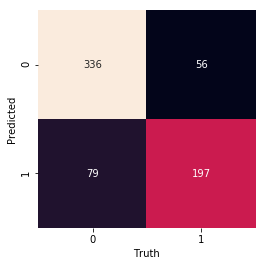

In [37]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(pred_train, y_train)
names = np.unique(pred_train)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names, yticklabels=names)

plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

Fit k-Nearest Neighbors model with different n values:

In [39]:
from sklearn.neighbors import KNeighborsClassifier
training_accuracy_knn = []
test_accuracy_knn = [] 
neighbors = list(range(1, 11))
for n in neighbors: 
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    pred_train = knn.predict(X_train)
    pred_test = knn.predict(X_test)
    training_accuracy_knn.append(round(knn.score(X_train, y_train)*100, 2))
    test_accuracy_knn.append(round(knn.score(X_test, y_test)*100, 2))

Plot the curve to show how accuracy depends on n parameter and select optimal value of n:

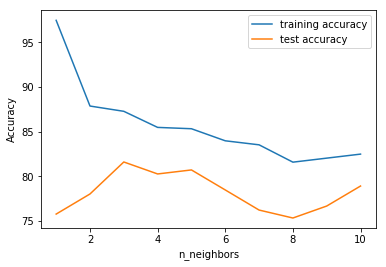

In [40]:
plt.plot(neighbors, training_accuracy_knn, label="training accuracy")
plt.plot(neighbors, test_accuracy_knn, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [48]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
pred_test = knn.predict(X_test)
accuracy_train = round(knn.score(X_train, y_train) * 100, 2)
accuracy_test = round(knn.score(X_test, y_test) * 100, 2)
print(accuracy_train)
print(accuracy_test)

87.28
81.61


Try LinearSVC with parameters dictionary:

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

parameters = {'C':[1, 3, 7, 10, 100], 
             'tol' : [0.1,0.01,0.001,10,1]}
linearSVC = LinearSVC(max_iter=100000, random_state=42)
clf = GridSearchCV(linearSVC, parameters, cv=5, scoring='accuracy')
clf.fit(X, y)

c:\users\nadine\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\nadine\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\nadine\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\nadine\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\nadine\appdata\local\programs\python\python

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 3, 7, 10, 100], 'tol': [0.1, 0.01, 0.001, 10, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [44]:
es = clf.best_estimator_ 

In [45]:
accuracy_train = round(es.score(X_train, y_train) * 100, 2)
accuracy_test = round(es.score(X_test, y_test) * 100, 2)
print(accuracy_train)
print(accuracy_test)

80.09
79.82


Try Logistic Regression:

In [46]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
accuracy_train = round(logreg.score(X_train, y_train) * 100, 2)
accuracy_test = round(logreg.score(X_test, y_test) * 100, 2)
print(accuracy_train)
print(accuracy_test)

80.39
79.82


In [47]:
from sklearn.linear_model import LogisticRegressionCV

lrcv = LogisticRegressionCV(Cs=[1, 3, 7, 10, 100], cv=5, solver='lbfgs',
                           class_weight='balanced', random_state=42)
lrcv.fit(X, y)

accuracy_train = round(lrcv.score(X_train, y_train) * 100, 2)
accuracy_test = round(lrcv.score(X_test, y_test) * 100, 2)
print(accuracy_train)
print(accuracy_test)

79.34
80.27
